## Wave Optics: ray tracing

#### Jesse van Rhijn
#### Wilson Tsong

## Assignment description

"Perform ray tracing on a tightly focused beam in air. Insert a **plan-parallel window with index $n$** and a thickness of 1 mm. See what happens to the **position** and the **quality of the focus** for values of **n between 1 and 3**, and for different values of the **$\mathrm{NA}$ (up to 0.9)**. Again, consider the **circle of least confusion**."

## Goals of the assignment:
* Observe the effects of a changing refractive index $n$ of the inserted window and numerical aperture $\mathrm{NA}$ to the focus of the beam. 

* Compute NA relative to focal plane, vary lens diameter

* Compute focal plane with Lensmaker's formula:

$$
    \frac{1}{f} = (n-1)\left( \frac{2}{R} + \frac{(n-1)t}{nR^2} \right)
$$

In [60]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from src.ray import Ray
from src.lens import Lens
from src.window import Window
from src.visualizer import Visualizer
%matplotlib inline

In [61]:
matplotlib.rcParams["figure.figsize"] = (20, 10)
matplotlib.rcParams["font.size"] = 18

In [62]:
def collimated_beam(start, width, nrays, angle=0):
    return [Ray(start, angle, z) for z in np.linspace(-width/2, width/2, nrays)]

In [63]:
diameter_lens = 1e-2
radius_lens = 1.5e-2
refractive_index = 1.5
position_lens = 1e-2

diameter_window = 1e-2
thickness_window = 0.001

beam_width = diameter_lens*0.8

beam = collimated_beam(0, beam_width, 10)

lens = Lens(
    position_lens,
    diameter_lens,
    radius_lens,
    refractive_index
)

position_window = (lens.focal_plane + position_lens)/2

window = Window(
    position_window,
    diameter_window,
    thickness_window,
    3
)

fp = lens.focal_plane

In [64]:
lens_rays = lens.interact_with_bundle(beam)
window_rays = window.interact_with_bundle(lens_rays)

## Example system

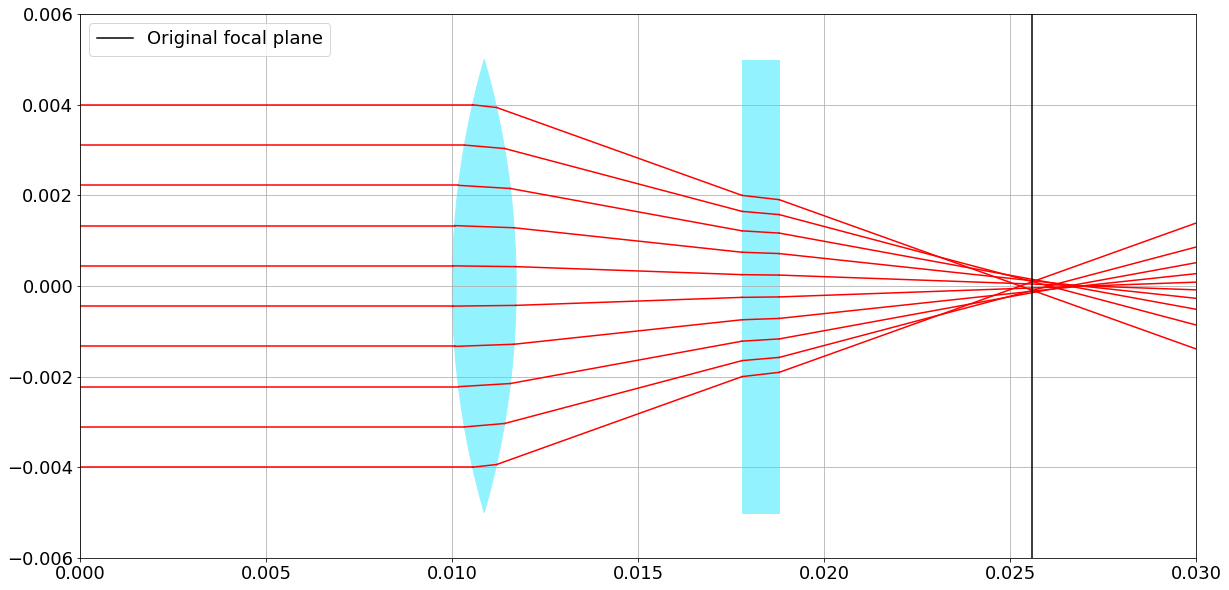

In [65]:
visualizer = Visualizer(beam + lens_rays + window_rays, [lens, window], (2e-2, 4e-2))
ax = visualizer.draw_all('r')
_ = ax.set_xlim(0, 0.03)
_ = ax.set_ylim(-0.006, 0.006)
ax.grid(True)
ax.plot([fp, fp], [-0.5, 0.5], color='black', label="Original focal plane")
_ = plt.legend()

In [66]:
def bundle_width(ray_bundle, xcoords):
    max_dist = np.zeros((len(ray_bundle), len(xcoords)))
    
    for j, ray in enumerate(ray_bundle):
        
        ys = ray.as_coordinate_array(xcoords)
        distances = np.zeros((len(ray_bundle), len(xcoords))) 
        
        for i, other_ray in enumerate(ray_bundle):
            distances[i, :] = np.abs(ys 
                                     - other_ray.as_coordinate_array(xcoords))
            
        max_dist[j, :] = distances.max(axis=0)
        
    return max_dist.max(axis=0)

In [67]:
def get_window_from_refractive_index(n, lens):
    THICKNESS = 0.001
    position = (lens.position + lens.focal_plane)/2
    return Window(position, lens.diameter, THICKNESS, n)

In [68]:
from copy import deepcopy
ns = np.linspace(1, 3, 200)

LENS = deepcopy(lens)

colc = []
colc_location = []
xs = np.linspace(window.position, 2*LENS.focal_plane, 10000)

for n in ns:
    window = get_window_from_refractive_index(n, LENS)
    beam = collimated_beam(0, LENS.diameter*0.8, 10)
    lens_rays = LENS.interact_with_bundle(beam)
    window_rays = window.interact_with_bundle(lens_rays)
    window_rays_free = window_rays[len(window_rays)//2:]
    width = bundle_width(window_rays_free, xs)
    
    colc.append(width.min())
    colc_location.append(xs[width.argmin()])
colc = np.array(colc)
colc_location = np.array(colc_location)

## Varying $n$

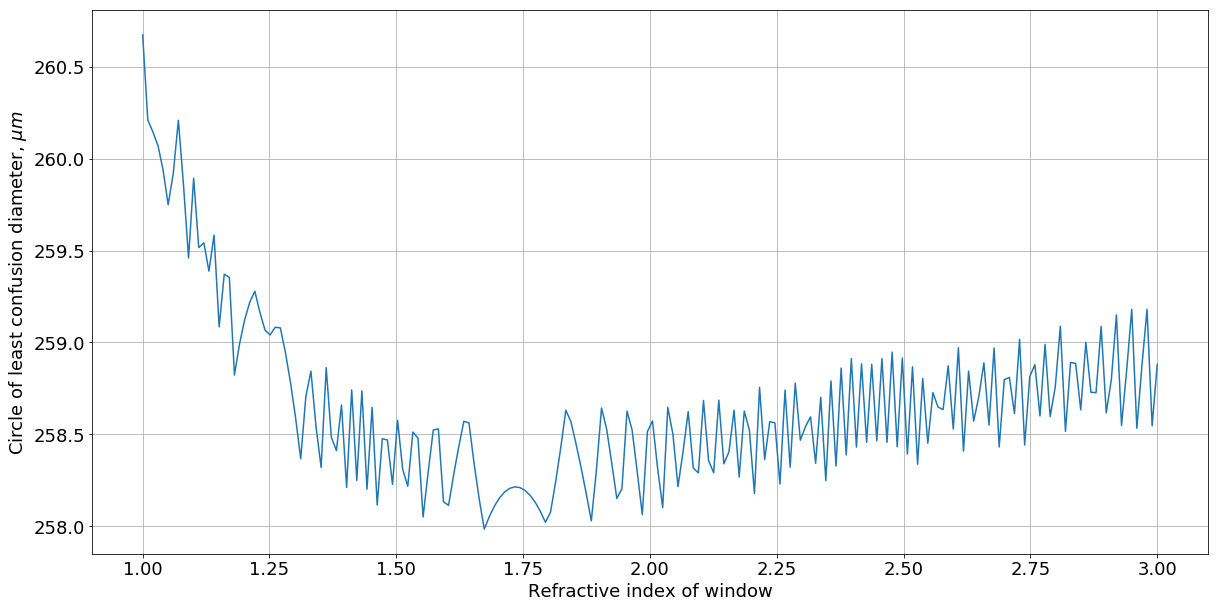

In [69]:
plt.plot(ns, colc*1e6)
plt.xlabel("Refractive index of window")
plt.ylabel("Circle of least confusion diameter, $\mu m$")
plt.grid(True)

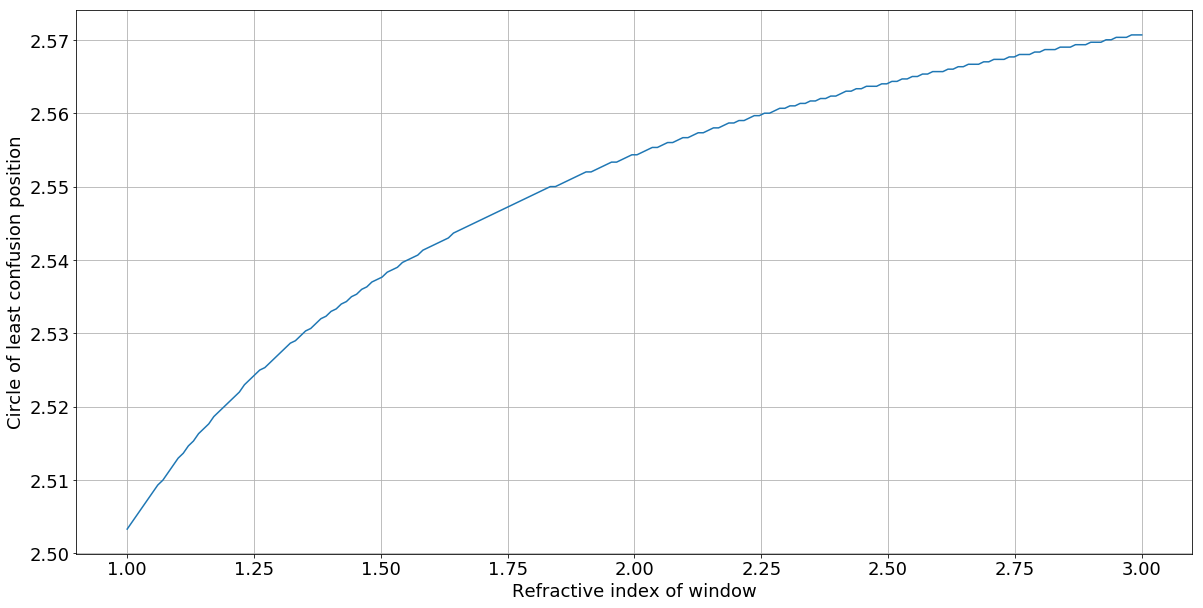

In [72]:
plt.plot(ns, colc_location*1e2)
plt.xlabel("Refractive index of window")
plt.ylabel("Circle of least confusion position")
plt.grid(True)

In [73]:
def get_lens_from_diameter(diameter):
    N = 1.5
    return Lens(position_lens, diameter, radius_lens, N)

In [91]:
diameters = np.linspace(0.8e-2, 2.9999e-2, 100)

colc = []
colc_location = []
na = []

for d in diameters:
    beam = collimated_beam(0, d*0.7, 10)
    lens = get_lens_from_diameter(d)
    position = (lens.focal_plane + lens.position)/2
    
    window = Window(position, d, 0.001, 1.5)
    lens_rays = lens.interact_with_bundle(beam)
    
    window_rays = window.interact_with_bundle(lens_rays)
    window_rays_free = window_rays[len(window_rays)//2:]
    
    xs = np.linspace(window.position, 2*lens.focal_plane, 10000)
    width = bundle_width(window_rays_free, xs)
    na.append(lens.numerical_aperture)
    
    colc.append(width.min())
    colc_location.append(xs[width.argmin()])
    
colc = np.array(colc)
colc_location = np.array(colc_location)
na = np.array(na)

## Varying NA

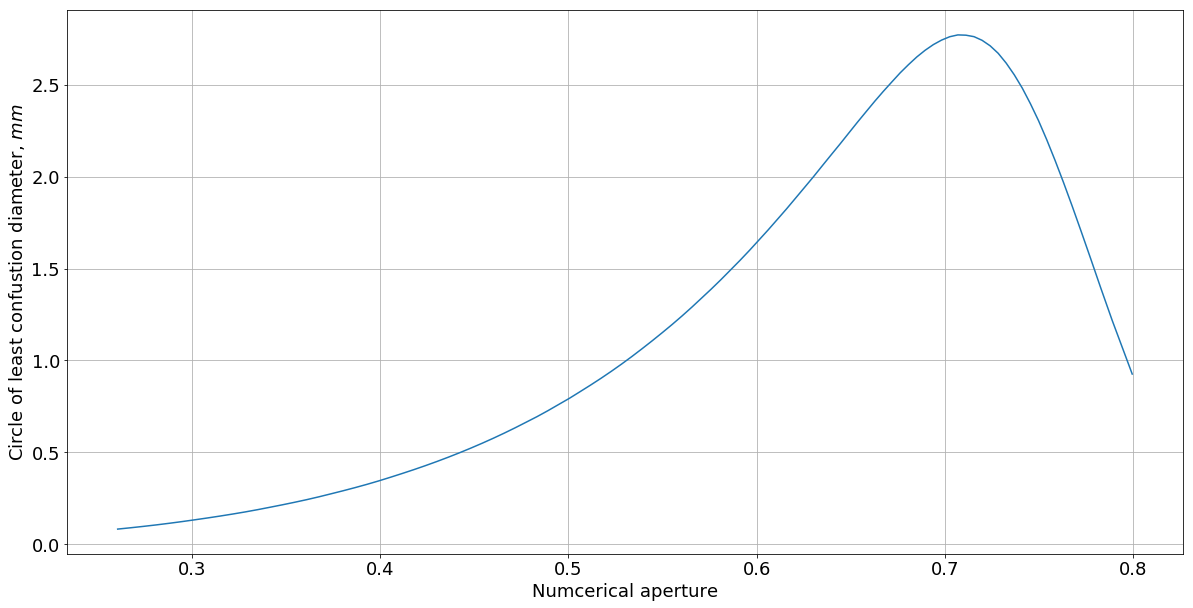

In [92]:
plt.plot(na, colc*1e3)
plt.xlabel("Numcerical aperture")
plt.ylabel("Circle of least confustion diameter, $mm$")
plt.grid(True)

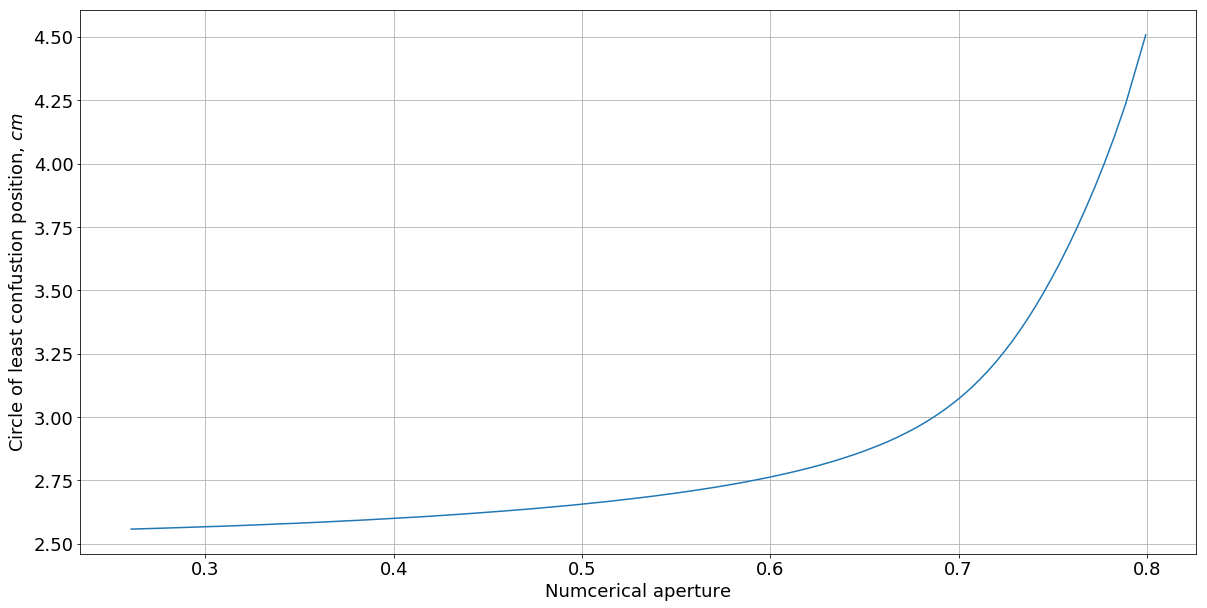

In [78]:
plt.plot(na, colc_location*100)
plt.xlabel("Numcerical aperture")
plt.ylabel("Circle of least confustion position, $cm$")
plt.grid(True)

## Conclusion

Varying $n$ introduces a spatial translation into the beam

Effect on focus quality width is negligible

For better results, use more rays (and more processing power...)

Varying $\mathrm{NA}$ translates focal point a small amount

Increasing $\mathrm{NA}$ by increasing $D$ also increases the beam width

This decreases the focus quality up to a point

After this point, the thickness increase of the lens overtakes and the focus improves